# Pseudowaveform Modeling

This notebook will show how the OpenOceans psuedowaveforms can be used individually, and how they underpin a sequential along track analysis. It's unlikely you'll need to process individual waveforms like we do here, as they're handled systematically by the models which output aggregated data. For this reason and for the sake of consistency/simplicity, we'll use a manually defined waveform to demonstrate how the model works. See other demos for how models process many waveforms at once using real data.

Last updated Jan 6 2023 by:<br />
__Jonathan Markel__<br />
Graduate Research Assistant<br />
3D Geospatial Laboratory<br />
The University of Texas at Austin<br />

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import the open oceans module
import sys
sys.path.append('..')
import openoceans as oo

## Extracting pseudowaveform

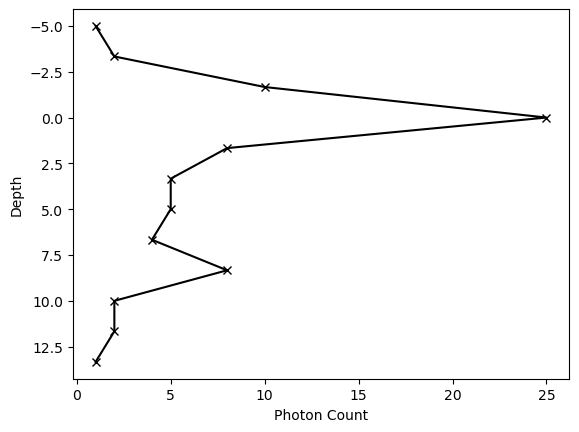

In [2]:
# making a fake wavefrom for now

# increasing in depth, decreasing in elevation
hist = np.array([1, 2, 10, 25, 8, 5, 5, 4, 8, 2, 2, 1])

# 25 value is the surface return
# 8 value is the seafloor return

# depth bins increasing L-R
depth_bin_edges = np.linspace(-5, 15, len(hist)+1)

# quick viz
plt.figure()
plt.plot(hist, depth_bin_edges[:-1], 'kx-')
plt.ylabel('Depth')
plt.xlabel('Photon Count')
plt.gca().invert_yaxis() # flip y axis for depth to make sense

## Modeling pseudowaveform

Waveform objects can be created from photon data histgrams and the corresponding histogram bins.

In [3]:
# print(oo.Waveform.__doc__)
pwave = oo.Waveform(hist, depth_bin_edges)

Use print() to show a quick text summary of the waveform statistics.

In [4]:
print(pwave)

----- PSEUDOWAVEFORM -----
TOTAL PHOTONS: 73
Depth Range : [-5.00m, 15.00m]
Depth Bin Count : 12
Peak Count : 2
Overall Quality Flag : 2
Bathymetry Confidence : -1
Fitted? : False

Initial Parameter Estimates:
    Surface Peak Location : 0.74m
    Bathy Peak Location : 8.93m
    Surface/Bathy Peak Ratio : 3.80
        


When the Waveform class is initialized, an estimate of model parameters is automatically calculated for whatever data is input. We can get a quick visualization of this model using the show() method.

Visualize histogram and model data in a plot.

        Args:
            hide_fitted (bool, optional): Whether or not to hide the fitted model from the plot if it's already been calculated. Defaults to False.

        Returns:
            f (pyplot figure): Matplolib Figure with data.
        


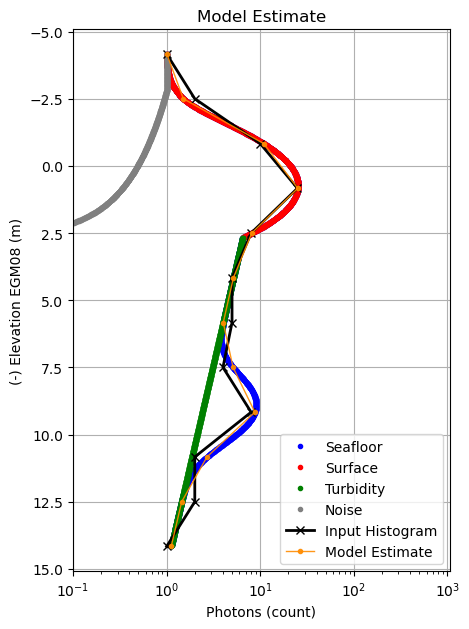

In [5]:
print(pwave.show.__doc__)
f = pwave.show()

The plot above shows model components for noise, surface returns, turbidity, and seafloor returns. These components are combined into the overall model (shown in orange).

Model components can also be accessed programmatically.

In [6]:
pwave.params

,initial,fitted
surf_prom,2.498755e+01,NaN
surf_loc,7.363512e-01,NaN
surf_std,1.174966e+00,NaN
decay_param,-1.529402e-01,NaN
trans_mult,1.640899e+00,NaN
noise_above,1.000000e+00,NaN
noise_below,1.000000e-31,NaN
bathy_prom,6.569637e+00,NaN
bathy_loc,8.933902e+00,NaN
bathy_std,9.344629e-01,NaN


We can see the parameters used to reconstruct the waveform, including surface peak depth (surf_loc), bathy peak prominence (bathy_prom) and more. The fitted column will be used in the next section.


The modeled histogram is also available. It can be accessed at the original depth resolution, or at an interpolated depth resolution (approximately 0.05 m). The interpolated resolution model is used with Waveform.show() to plot the model components (noise, seafloor, etc), while the original depth resolution is shown in orange.

In [7]:
# original resolution
pwave.model.head()

# interpolated resolution
# pwave.model_interp.head()

,input,depth,output,noise,surface,bathy,turbidity,output_f,noise_f,surface_f,bathy_f,turbidity_f
0,1,-4.166667,1.004135,1.000000,0.004135,1.376941e-42,0.0,NaN,NaN,NaN,NaN,NaN
1,2,-2.500000,1.509765,0.947084,0.562681,2.029480e-32,0.0,NaN,NaN,NaN,NaN,NaN
2,10,-0.833333,10.878438,0.641436,10.237002,1.242604e-23,0.0,NaN,NaN,NaN,NaN,NaN
3,25,0.833333,25.238362,0.335788,24.902574,3.160525e-16,0.0,NaN,NaN,NaN,NaN,NaN
4,8,2.500000,8.129985,0.030140,8.099845,3.339366e-10,0.0,NaN,NaN,NaN,NaN,NaN


## Fitting model

The histogram model can also be optimized using least squares and our initial estimate of model parameters.

In [8]:
print(oo.Waveform.fit.__doc__)

Attempts to fit the initially estimated histogram model to the original data. Returns dict of new model parameters, but also saves fitted model data to Waveform.params, Wavefrom.model, and Waveform.model_interp attributes for further analysis.

        Args:
            xtol (float, optional): Relative error desired in the approximate solution (passes to scipy least squares). Defaults to 1e-6.
            ftol (float, optional): Relative error desired in the sum of squares (passes to scipy least squares). . Defaults to 1e-6.

        Returns:
            dict: Dictionary of refined model parameters
        


In [9]:
# returns new parameters but also saves to class attribute model dataframes
pwave.fit()

array([ 2.17102858e+01,  7.76214423e-01,  1.24144906e+00, -1.41194254e-01,
        1.48740075e+00,  1.79954780e+00,  8.05410876e-13,  4.72072289e+00,
        9.10181162e+00,  7.62923679e-01])

Note that the model data with the subscript '_f' (for fitted model) have now been filled.

In [10]:
pwave.model.head()

,input,depth,output,noise,surface,bathy,turbidity,output_f,noise_f,surface_f,bathy_f,turbidity_f
0,1,-4.166667,1.004135,1.000000,0.004135,1.376941e-42,0.0,1.807388,1.799548,0.007840,9.858804e-66,0.0
1,2,-2.500000,1.509765,0.947084,0.562681,2.029480e-32,0.0,2.322140,1.654789,0.667351,2.869591e-50,0.0
2,10,-0.833333,10.878438,0.641436,10.237002,1.242604e-23,0.0,10.484605,1.116409,9.368196,7.066367e-37,0.0
3,25,0.833333,25.238362,0.335788,24.902574,3.160525e-16,0.0,22.265349,0.578030,21.687319,1.472152e-25,0.0
4,8,2.500000,8.129985,0.030140,8.099845,3.339366e-10,0.0,8.319150,0.039651,8.279499,2.594713e-16,0.0


We can again use show() to see our model and compare how well it captures the waveform compared to our estimate.

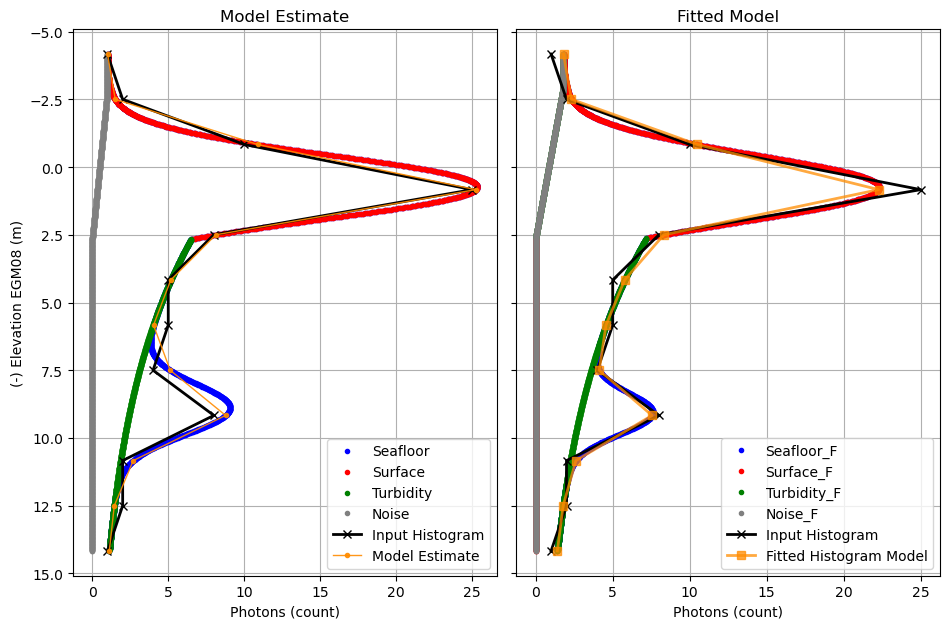

In [11]:
# ff = pwave.show()
ff = pwave.show(logplot=False)

As shown above, our initial estimate wasn't too far off, but re-fitting the overall model results in further improvement if desired and willing to wait out the extra computational time.
